In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import uniform, invgamma, bernoulli, poisson, norm
import statsmodels.api as sm
import pandas as pd
from src.preprocessing import prepare_data, prepare_data_no_standardizing, MAR_data_deletion
from src.model_code import Gibbs_MH
import pymc3 as pm
import arviz as az
from statsmodels.tsa.stattools import acf 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('student-mat.csv', sep=",")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
df.head()

,age,sex,failures,higher,Medu,absences,G2,G3
0,18,F,0,yes,4,6,6,6
1,17,F,0,yes,1,4,5,6
2,15,F,3,yes,1,10,8,10
3,15,F,0,yes,4,2,14,15
4,16,F,0,yes,3,4,10,10


In [4]:
X_df, y_df = prepare_data_no_standardizing(df)
X_df.head()

,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6,6,0,1,1
1,17,0,1,4,5,0,1,1
2,15,3,1,10,8,0,1,1
3,15,0,4,2,14,0,1,1
4,16,0,3,4,10,0,1,1


In [5]:
X_df_missing = MAR_data_deletion(X_df, 0.05, 0.05, 'higher_yes', 'G2')
X_df_missing

,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6,6.0,0,1.0,1
1,17,0,1,4,5.0,0,1.0,1
2,15,3,1,10,8.0,0,1.0,1
3,15,0,4,2,14.0,0,1.0,1
4,16,0,3,4,10.0,0,1.0,1
...,...,...,...,...,...,...,...,...
390,20,2,2,11,NaN,1,1.0,1
391,17,0,3,3,16.0,1,1.0,1
392,21,3,1,3,NaN,1,1.0,1
393,18,0,3,0,12.0,1,1.0,1


In [6]:
X = X_df_missing
y = y_df.to_numpy()
B = 1000
n = len(y)
thin = 10

In [7]:
(betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas) = Gibbs_MH(X, y, B, n, thin)

100%|██████████| 19999/19999 [02:48<00:00, 118.49it/s]


In [8]:
betas_df = pd.DataFrame(betas.T, columns=[f"beta_{i}" for i in X_df.columns])
higher_yes_df = pd.DataFrame(higher_yes_sim.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])
G2_df = pd.DataFrame(G2_sim.T, columns=[f"missing_G2_{i}" for i in range(0, G2_sim.shape[0])])
alphas_df = pd.DataFrame(alphas.T, columns=[f"alpha_{i}" for i in range(0, alphas.shape[0])])
gammas_df = pd.DataFrame(gammas.T, columns=[f"gamma_{i}" for i in range(0, gammas.shape[0])])
rest_df = pd.DataFrame({"sigmas2": sigmas2.T,
                        "eta2": etas.T})

In [9]:
results = pd.concat([betas_df , higher_yes_df, G2_df, alphas_df, gammas_df, rest_df], axis=1) 
results.head()
results.to_csv("results/03_results_not_thinned_(G2).csv")

In [10]:
def MCMC_diagnostics(chain, param):
    plt.subplot(411)
    plt.plot(chain)
    plt.title(f'Trace Plot {param}')

    plt.subplot(412)
    plt.hist(chain, bins=60)
    plt.title(f'Histogram {param}')

    plt.subplot(413)
    gw_plot = pm.geweke(chain)
    plt.scatter(gw_plot[:,0],gw_plot[:,1])
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    
    plt.ylim(-2.5,2.5)
    plt.title(f'Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain {param}')

    plt.subplot(414)
    acf_values = acf(chain)
    plt.scatter(range(0, len(acf_values)), acf_values)
    plt.title(f'ACF {param}')
    
    plt.tight_layout()
    plt.show()

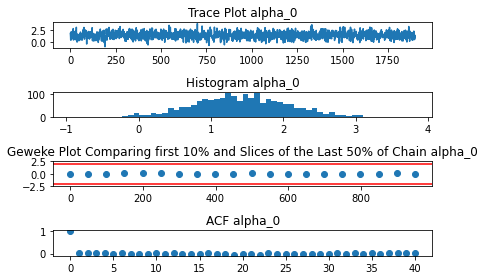

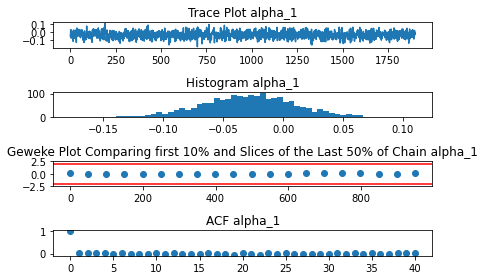

In [11]:
for i, alpha in enumerate(alphas):
    MCMC_diagnostics(alpha, f"alpha_{i}")

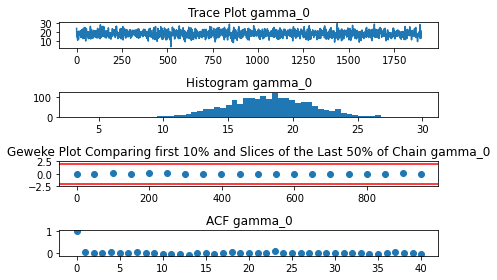

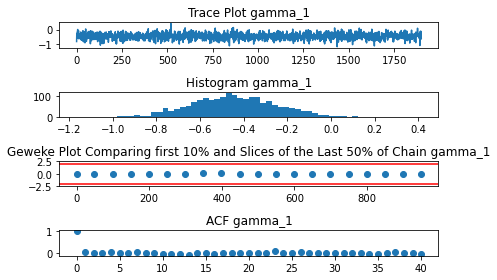

In [12]:
for i, gamma in enumerate(gammas):
    MCMC_diagnostics(gamma, f"gamma_{i}")

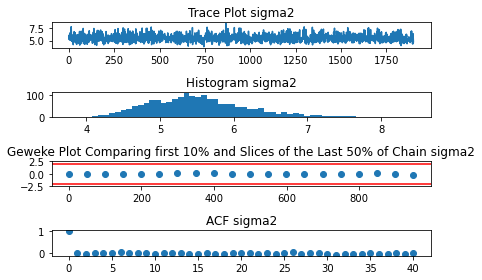

In [13]:
MCMC_diagnostics(sigmas2, "sigma2")

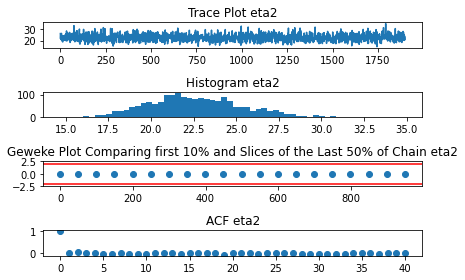

In [14]:
MCMC_diagnostics(etas, "eta2")

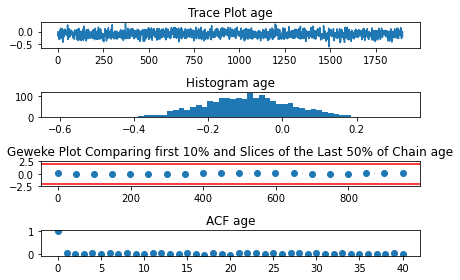

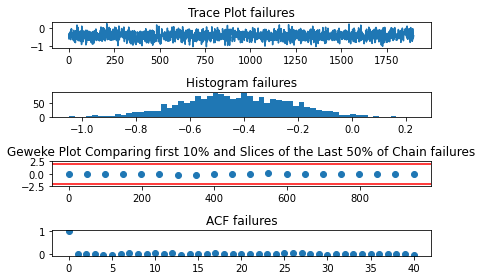

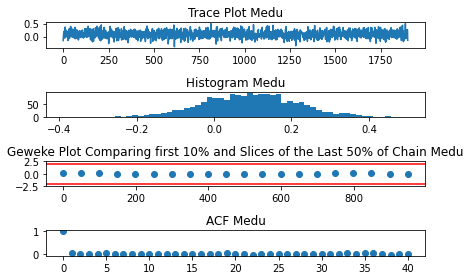

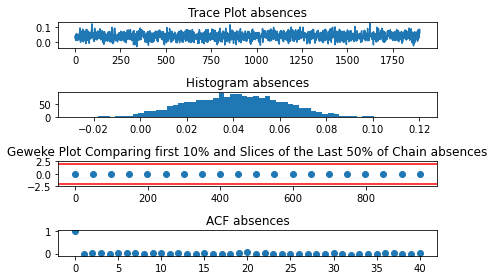

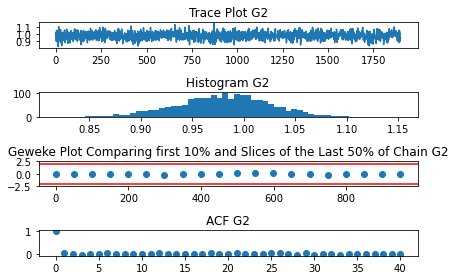

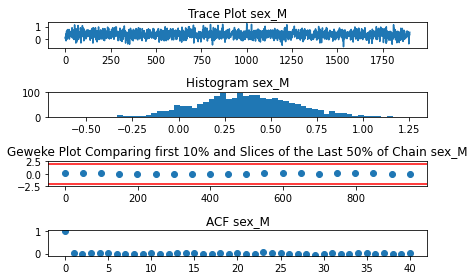

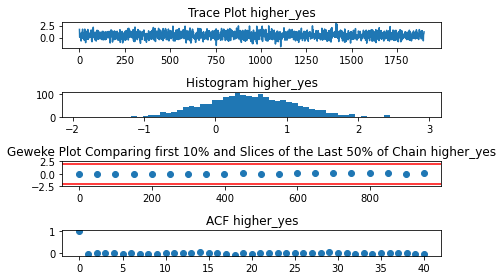

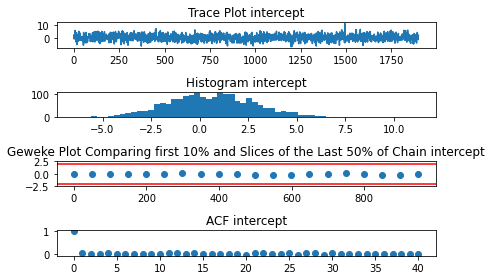

In [15]:
for i, beta in enumerate(betas):
    MCMC_diagnostics(beta, X_df.columns[i])

In [16]:
# thin
"""betas_thin = betas[:, ::thin]
higher_yes_sim_thin = higher_yes_sim[:, ::thin]
absences_sim_thin = absences_sim[:, ::thin]
alphas0_thin = alphas0[::thin]
alphas1_thin = alphas1[::thin]
gammas0_thin = gammas0[::thin]
gammas1_thin = gammas1[::thin]
sigmas2_thin = sigmas2[::thin]"""

'betas_thin = betas[:, ::thin]\nhigher_yes_sim_thin = higher_yes_sim[:, ::thin]\nabsences_sim_thin = absences_sim[:, ::thin]\nalphas0_thin = alphas0[::thin]\nalphas1_thin = alphas1[::thin]\ngammas0_thin = gammas0[::thin]\ngammas1_thin = gammas1[::thin]\nsigmas2_thin = sigmas2[::thin]'

In [17]:
"""MCMC_diagnostics(alphas0_thin, "alpha0")
MCMC_diagnostics(alphas1_thin, "alpha1")
MCMC_diagnostics(gammas0_thin, "gamma0")
MCMC_diagnostics(gammas1_thin, "gamma1")"""

'MCMC_diagnostics(alphas0_thin, "alpha0")\nMCMC_diagnostics(alphas1_thin, "alpha1")\nMCMC_diagnostics(gammas0_thin, "gamma0")\nMCMC_diagnostics(gammas1_thin, "gamma1")'

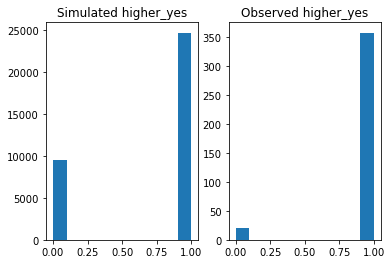

In [18]:
plt.subplot(121)
plt.hist(higher_yes_sim.flatten())
plt.title(f'Simulated higher_yes')


plt.subplot(122)
plt.hist(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')

plt.show()

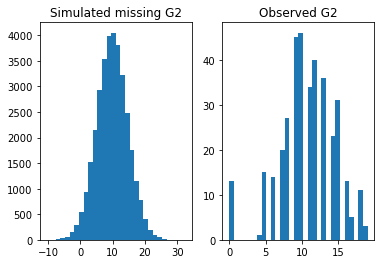

In [19]:
plt.subplot(121)
plt.hist(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
plt.hist(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')
plt.show()



In [20]:
"""betas_df_thinned = pd.DataFrame(betas_thin.T, columns=[f"beta_{i}" for i in X_df.columns])
higher_yes_df_thinned = pd.DataFrame(higher_yes_sim_thin.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])
absences_df_thinned = pd.DataFrame(absences_sim_thin.T, columns=[f"missing_absences_{i}" for i in range(0, absences_sim.shape[0])])
rest_df_thinned = pd.DataFrame({"sigmas2": sigmas2_thin.T,
              "alpha0": alphas0_thin.T,
              "alphas1": alphas1_thin.T,
              "gammas0": gammas0_thin.T, 
              "gammas1": gammas1_thin.T
             })
              
results_thinned = pd.concat([betas_df_thinned, higher_yes_df_thinned, absences_df_thinned, rest_df_thinned], axis=1) 
results_thinned.to_csv("results/03results_thinned.csv")"""
              

'betas_df_thinned = pd.DataFrame(betas_thin.T, columns=[f"beta_{i}" for i in X_df.columns])\nhigher_yes_df_thinned = pd.DataFrame(higher_yes_sim_thin.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])\nabsences_df_thinned = pd.DataFrame(absences_sim_thin.T, columns=[f"missing_absences_{i}" for i in range(0, absences_sim.shape[0])])\nrest_df_thinned = pd.DataFrame({"sigmas2": sigmas2_thin.T,\n              "alpha0": alphas0_thin.T,\n              "alphas1": alphas1_thin.T,\n              "gammas0": gammas0_thin.T, \n              "gammas1": gammas1_thin.T\n             })\n              \nresults_thinned = pd.concat([betas_df_thinned, higher_yes_df_thinned, absences_df_thinned, rest_df_thinned], axis=1) \nresults_thinned.to_csv("results/03results_thinned.csv")'